# notebook to sweep different FD thresholds and see how many subjects remain!

In [6]:
import os
import glob
from pathlib import Path
#from dotenv import load_dotenv
import pandas as pd
import numpy as np
# import dask.dataframe as dd
# import dask.bag as db

import matplotlib.pyplot as plt
import seaborn as sns


## first add threshold data to the qc csv (collapse unless re-running)

In [2]:
all_qc = pd.read_csv(  f"../data/all_qc.csv"  )

In [6]:
all_qc['sub']
all_qc['task']

0       movieDM
1       movieDM
2       movieDM
3       movieDM
4       movieDM
         ...   
8786       rest
8787       rest
8788       rest
8789       rest
8790       rest
Name: task, Length: 8791, dtype: object

In [16]:

all_qc[:10]

,aor,aqi,bids_meta,dummy_trs,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,...,summary_fg_p95,summary_fg_stdv,tsnr,subj_id,run_bad,ses,sub,task,relaxed_fd50,dorit_fd40
0,0.001634,0.011370,"{'AcquisitionMatrixPE': 84, 'BandwidthPerPixel...",0,31.320980,0.998533,0.988834,0.489231,1225.898438,0.149726,...,554.858643,114.659175,31.901540,sub-NDARAA306NT2,movieDM,HBNsiteRU,NDARAA306NT2,movieDM,1,1
1,0.030871,0.069020,"{'AcquisitionMatrixPE': 84, 'BandwidthPerPixel...",0,100.102069,1.191695,1.183819,0.537480,677.013855,2.853728,...,2578.733398,543.516007,11.624881,sub-NDARAA947ZG5,movieDM,HBNsiteCBIC,NDARAA947ZG5,movieDM,0,0
2,0.000461,0.004402,"{'AcquisitionMatrixPE': 84, 'BandwidthPerPixel...",2,26.360379,1.038065,0.995616,0.480758,2013.960938,0.120238,...,604.933167,120.056921,46.489295,sub-NDARAA948VFH,movieDM,HBNsiteRU,NDARAA948VFH,movieDM,1,1
3,0.014249,0.051829,"{'AcquisitionMatrixPE': 84, 'BandwidthPerPixel...",4,62.831196,1.060205,1.054771,0.510687,1170.000854,1.230934,...,445.487946,81.522293,14.618530,sub-NDARAB055BPR,movieDM,HBNsiteRU,NDARAB055BPR,movieDM,0,0
4,0.001283,0.010898,"{'AcquisitionMatrixPE': 84, 'BandwidthPerPixel...",0,48.614155,1.172940,0.991999,0.535286,908.762024,0.342414,...,6333.021484,1370.364640,29.789868,sub-NDARAB282FDJ,movieDM,HBNsiteCUNY,NDARAB282FDJ,movieDM,0,0
5,0.010429,0.023842,"{'AcquisitionMatrixPE': 84, 'BandwidthPerPixel...",0,54.260690,1.050079,0.991560,0.514512,1087.080444,0.608782,...,3365.074707,695.106832,20.590258,sub-NDARAB348EWR,movieDM,HBNsiteCBIC,NDARAB348EWR,movieDM,0,0
6,0.000821,0.006552,"{'AcquisitionMatrixPE': 84, 'BandwidthPerPixel...",4,37.400328,1.072347,1.004517,0.529474,823.885742,0.149393,...,3071.639404,640.163991,38.052518,sub-NDARAB458VK9,movieDM,HBNsiteCBIC,NDARAB458VK9,movieDM,1,1
7,0.001119,0.011860,"{'AcquisitionMatrixPE': 84, 'BandwidthPerPixel...",2,45.495832,1.128268,0.999489,0.515749,1154.753662,0.255216,...,3050.532227,613.563923,31.289108,sub-NDARAB514MAJ,acq-VARIANTObliquity,HBNsiteCBIC,NDARAB514MAJ,movieDM,0,0
8,0.000283,0.005256,"{'AcquisitionMatrixPE': 84, 'BandwidthPerPixel...",1,40.103689,1.107372,1.002612,0.542568,915.536743,0.112665,...,2969.220459,608.166878,39.796377,sub-NDARAB653ZXP,movieDM,HBNsiteCBIC,NDARAB653ZXP,movieDM,1,1
9,0.010143,0.024974,"{'AcquisitionMatrixPE': 84, 'BandwidthPerPixel...",0,58.692195,1.090858,1.044305,0.546039,717.718750,0.750295,...,3335.664062,749.357802,17.380910,sub-NDARAB708LM5,movieDM,HBNsiteCBIC,NDARAB708LM5,movieDM,0,0


In [56]:
import glob
import pandas as pd

def check_timepoints(data, threshold, proportion_threshold):

    # Count the number of elements greater than the threshold
    count_greater = sum(1 for x in data if x > threshold)
    
    # Calculate the proportion
    proportion = count_greater / len(data)
    
    # Return 1 if the proportion is greater than 40%, otherwise return 0
    return 0 if proportion > proportion_threshold else 1



def process_row(row):
    sub = row['sub']
    task = row['task']
    ses = row['ses']
    
    # Build the pattern to match any confounds file for the subject, session, and task
    pattern = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/fmriprep_23.2.0/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_*desc-confounds_timeseries.tsv'
    
    # Use glob to find the matching file
    confounds_files = glob.glob(pattern)
    
    if confounds_files:
        confounds_file = confounds_files[0]  # Take the first match if there are multiple
        # Read the confounds file
        df_confounds = pd.read_csv(confounds_file, sep='\t')
        thresh_02_04=check_timepoints(df_confounds['framewise_displacement'], 0.2, 0.4)
        thresh_02_06=check_timepoints(df_confounds['framewise_displacement'], 0.2, 0.6)
        thresh_02_08=check_timepoints(df_confounds['framewise_displacement'], 0.2, 0.8)
        thresh_04_04=check_timepoints(df_confounds['framewise_displacement'], 0.4, 0.4)
        thresh_06_04=check_timepoints(df_confounds['framewise_displacement'], 0.6, 0.4)
        thresh_08_04=check_timepoints(df_confounds['framewise_displacement'], 0.8, 0.4)
        
        return(thresh_02_04,thresh_02_06,thresh_02_08,thresh_04_04,thresh_06_04,thresh_08_04)
    else:
        # Handle the case where no matching file is found (e.g., log a message or return None)
        print(f"No confounds file found for sub-{sub}, ses-{ses}, task-{task}")
        return None

# Apply the function and store the results in the new DataFrame
x=all_qc[:10].apply(process_row, axis=1)

# # Optionally, you can also copy other relevant columns (like 'sub', 'task', 'ses') from all_qc to fd
# fd[['sub', 'task', 'ses']] = all_qc[['sub', 'task', 'ses']][:10]

# # Display the new DataFrame with framewise displacement values
# fd.head()
x

0    (1, 1, 1, 1, 1, 1)
1    (0, 0, 1, 0, 1, 1)
2    (1, 1, 1, 1, 1, 1)
3    (0, 0, 1, 0, 1, 1)
4    (0, 0, 1, 1, 1, 1)
5    (0, 1, 1, 1, 1, 1)
6    (1, 1, 1, 1, 1, 1)
7    (0, 1, 1, 1, 1, 1)
8    (1, 1, 1, 1, 1, 1)
9    (0, 1, 1, 1, 1, 1)
dtype: object

In [ ]:
# Apply process_row to all_qc and unpack the result directly into new columns
all_qc[['thresh_02_04', 'thresh_02_06', 'thresh_02_08', 'thresh_04_04', 'thresh_06_04', 'thresh_08_04']] = pd.DataFrame(all_qc.apply(process_row, axis=1).tolist())

# Optionally, inspect the result
print(all_qc.head())


In [58]:
all_qc.to_csv('../data/all_qc_sweep.csv', index=False)

In [61]:
all_qc[:1]

,aor,aqi,bids_meta,dummy_trs,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,...,sub,task,relaxed_fd50,dorit_fd40,thresh_02_04,thresh_02_06,thresh_02_08,thresh_04_04,thresh_06_04,thresh_08_04
0,0.001634,0.01137,"{'AcquisitionMatrixPE': 84, 'BandwidthPerPixel...",0,31.32098,0.998533,0.988834,0.489231,1225.898438,0.149726,...,NDARAA306NT2,movieDM,1,1,1.0,1.0,1.0,1.0,1.0,1.0


In [63]:
nat_img_dir='/nese/mit/group/sig/projects/naturalistic/nat_img/'
dx_final=pd.read_csv(f'{nat_img_dir}sourcedata/data/HBN/phenotype/parsed/dx_onehot.csv')


In [64]:
dx_final

,Identifiers,Age,Sex,Site,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,...,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Feeding or Eating Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
0,NDARAA075AMK,6.728040,female,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NDARAA112DMH,5.545744,male,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NDARAA117NEJ,7.475929,male,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NDARAA306NT2,21.216746,female,3,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NDARAA358BPN,11.853296,male,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4762,NDARZT957CWG,16.034565,male,3,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4763,NDARZU401RCU,17.663586,female,3,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4764,NDARZV458LDP,15.763175,female,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4765,NDARZX745YLZ,16.288501,male,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# list the columns of the dataframe


In [66]:
all_qc_dx = pd.merge(all_qc, dx_final, left_on='sub', right_on='Identifiers', how='left')

In [68]:
all_qc_dx.to_csv('../data/all_qc_sweep_dx.csv', index=False)

## add the SRS to it as well

In [93]:
srs = pd.read_csv('/nese/mit/group/sig/projects/hbn/phenotype/Parent_Measures/Demographic_Questionnaire_Measures/SRS.csv')
srs = srs[['Identifiers', 'SRS,SRS_20', 'SRS,SRS_42', 'SRS,SRS_58', 'SRS,SRS_Total', 'SRS,SRS_Total_T']]

srs = srs.rename(columns={
    'SRS,SRS_20': 'SRS_20',
    'SRS,SRS_42': 'SRS_42',
    'SRS,SRS_58': 'SRS_58',
    'SRS,SRS_Total': 'SRS_Total',
    'SRS,SRS_Total_T': 'SRS_Total_T'
})

srs_pre = pd.read_csv('/nese/mit/group/sig/projects/hbn/phenotype/Parent_Measures/Demographic_Questionnaire_Measures/SRS_Pre.csv')
srs_pre = srs_pre[['Identifiers', 'SRS_Pre,SRS_P_20', 'SRS_Pre,SRS_P_42', 'SRS_Pre,SRS_P_58', 'SRS_Pre,SRS_Total', 'SRS_Pre,SRS_Total_T']]

srs_pre = srs_pre.rename(columns={
    'SRS_Pre,SRS_P_20': 'SRS_20',
    'SRS_Pre,SRS_P_42': 'SRS_42',
    'SRS_Pre,SRS_P_58': 'SRS_58',
    'SRS_Pre,SRS_Total': 'SRS_Total',
    'SRS_Pre,SRS_Total_T': 'SRS_Total_T'
})

srs = pd.concat([srs, srs_pre])

In [97]:
all_qc_sweep_dx['Identifiers']

0       NDARAA306NT2
1       NDARAA947ZG5
2       NDARAA948VFH
3       NDARAB055BPR
4       NDARAB282FDJ
            ...     
8786    NDARZY668NMV
8787    NDARZZ046HJA
8788    NDARZZ598MH8
8789    NDARZZ740MLM
8790    NDARZZ810LVF
Name: Identifiers, Length: 8791, dtype: object

In [98]:
all_qc_sweep_dx = pd.read_csv(  f"../data/all_qc_sweep_dx.csv"  )

all_qc_sweep_dx_srs = pd.merge(all_qc_sweep_dx, srs, left_on='Identifiers', right_on='Identifiers', how='left')

In [101]:
all_qc_sweep_dx_srs
all_qc_sweep_dx_srs.to_csv('../data/all_qc_sweep_dx.csv', index=False)

## load the saved qc csv

In [105]:
all_qc_sweep_dx = pd.read_csv(  f"../data/all_qc_sweep_dx.csv"  )

#print for all sites:
#number

In [106]:

column_names = all_qc_sweep_dx.columns.tolist()
for col in column_names:
    print(col)

aor
aqi
bids_meta
dummy_trs
dvars_nstd
dvars_std
dvars_vstd
efc
fber
fd_mean
fd_num
fd_perc
fwhm_avg
fwhm_x
fwhm_y
fwhm_z
gcor
gsr_x
gsr_y
provenance
size_t
size_x
size_y
size_z
snr
spacing_tr
spacing_x
spacing_y
spacing_z
summary_bg_k
summary_bg_mad
summary_bg_mean
summary_bg_median
summary_bg_n
summary_bg_p05
summary_bg_p95
summary_bg_stdv
summary_fg_k
summary_fg_mad
summary_fg_mean
summary_fg_median
summary_fg_n
summary_fg_p05
summary_fg_p95
summary_fg_stdv
tsnr
subj_id
run_bad
ses
sub
task
relaxed_fd50
dorit_fd40
thresh_02_04
thresh_02_06
thresh_02_08
thresh_04_04
thresh_06_04
thresh_08_04
Identifiers
Age
Sex
Site
ADHD-Combined Type
ADHD-Hyperactive/Impulsive Type
ADHD-Inattentive Type
Acute Stress Disorder
Adjustment Disorders
Agoraphobia
Alcohol Use Disorder
Anorexia Nervosa-Binge Eating/Purging Type
Anorexia Nervosa-Restricting Type
Autism Spectrum Disorder
Avoidant/Restrictive Food Intake Disorder
Binge-Eating Disorder
Bipolar I Disorder
Bipolar II Disorder
Body Dysmorphic Diso

In [107]:
# make a new dataframe all_qc_sweep_dx_nat where it is only rows with task = movieDM or movieTP
all_qc_sweep_dx_DM = all_qc_sweep_dx[all_qc_sweep_dx['task'].isin(['movieDM'])]
all_qc_sweep_dx_DM = all_qc_sweep_dx_DM[all_qc_sweep_dx_DM['thresh_08_04'].notna()] #remove subjects with no fmriprep
all_qc_sweep_dx_DM = all_qc_sweep_dx_DM[all_qc_sweep_dx_DM['Autism Spectrum Disorder'].notna()] #remove subjects with no dx


all_qc_sweep_dx_TP = all_qc_sweep_dx[all_qc_sweep_dx['task'].isin(['movieTP'])]
all_qc_sweep_dx_TP = all_qc_sweep_dx_TP[all_qc_sweep_dx_TP['thresh_08_04'].notna()] #remove subjects with no fmriprep
all_qc_sweep_dx_TP = all_qc_sweep_dx_TP[all_qc_sweep_dx_TP['Autism Spectrum Disorder'].notna()] #remove subjects with no dx

In [109]:
all_qc_sweep_dx_DM['SRS_Total_T'].mean()

56.96450360510261

## plot!

In [162]:
def plot_threshold_sweep(df, thresholds, title):
    # Initialize lists to store the counts
    asd_counts = []
    no_diagnosis_counts = []
    total_counts = []
    
    # Initialize lists to store the mean SRS scores
    total_srs_means = []
    asd_srs_means = []
    no_diagnosis_srs_means = []

    # Initialize lists to store the mean Ages
    total_age_means = []
    asd_age_means = []
    no_diagnosis_age_means = []
    
    # Calculate the counts and mean SRS_Total_T for each threshold
    for threshold in thresholds:
        total = len(df[df[threshold] == 1])
        asd_count = len(df[(df[threshold] == 1) & (df['Autism Spectrum Disorder'] == 1)])
        no_diagnosis_count = len(df[(df[threshold] == 1) & (df['No Diagnosis Given'] == 1)])
        
        total_counts.append(total)
        asd_counts.append(asd_count)
        no_diagnosis_counts.append(no_diagnosis_count)

        # Calculate means for each category
        total_srs_means.append(df[df[threshold] == 1]['SRS_Total_T'].mean())
        asd_srs_means.append(df[(df[threshold] == 1) & (df['Autism Spectrum Disorder'] == 1)]['SRS_Total_T'].mean())
        no_diagnosis_srs_means.append(df[(df[threshold] == 1) & (df['No Diagnosis Given'] == 1)]['SRS_Total_T'].mean())

        # Calculate means for each category AGE
        total_age_means.append(df[df[threshold] == 1]['Age'].mean())
        asd_age_means.append(df[(df[threshold] == 1) & (df['Autism Spectrum Disorder'] == 1)]['Age'].mean())
        no_diagnosis_age_means.append(df[(df[threshold] == 1) & (df['No Diagnosis Given'] == 1)]['Age'].mean())

    # Grouped bar plot
    x = np.arange(len(thresholds))  # the label locations
    width = 0.3  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.bar(x - width, [len(df)] * len(thresholds), width, color='lightgray')
    ax.bar(x, [len(df[df['Autism Spectrum Disorder'] == 1])] * len(thresholds), width, color='lightgray')
    ax.bar(x + width, [len(df[df['No Diagnosis Given'] == 1])] * len(thresholds), width, color='lightgray')

    # Plot bars for each group
    rects1 = ax.bar(x - width, total_counts, width, label='Total')
    rects2 = ax.bar(x, asd_counts, width, label='Autism Spectrum Disorder')
    rects3 = ax.bar(x + width, no_diagnosis_counts, width, label='No Diagnosis Given')
    
    # Add horizontal line
    ax.axhline(y=len(df), color='r', linestyle='--')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Thresholds')
    ax.set_ylabel('Counts')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(thresholds, rotation=45)
    ax.legend()
    
    # Add labels above each bar
    def add_labels(rects, srs_means, age_means):
        ax.annotate(f'SRS:',
            xy=(-0.5, 0), 
            xytext=(-5, -5),  # Adjust the vertical offset to display below the bar
            textcoords="offset points",
            ha='center', va='top', fontsize=9, color='red')
        ax.annotate(f'Age:',
            xy=(-0.5, 0), 
            xytext=(-5, -15),  # Adjust the vertical offset to display below the bar
            textcoords="offset points",
            ha='center', va='top', fontsize=9, color='blue')
        for rect, mean, mean_age in zip(rects, srs_means, age_means):
            height = rect.get_height()
        
            ax.annotate(f'{height}',  # label for the height of the bar
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
            
            # Add mean SRS score below the bar
            ax.annotate(f'{mean:.1f}',
                        xy=(rect.get_x() + rect.get_width() / 2, 0), 
                        xytext=(0, -5),  # Adjust the vertical offset to display below the bar
                        textcoords="offset points",
                        ha='center', va='top', fontsize=9, color='red')

            # Add mean Age below the bar
            ax.annotate(f'{mean_age:.1f}',
                        xy=(rect.get_x() + rect.get_width() / 2, 0), 
                        xytext=(0, -15),  # Adjust the vertical offset to display below the bar
                        textcoords="offset points",
                        ha='center', va='top', fontsize=9, color='blue')

    # Call the function for all the bars and corresponding mean SRS values
    add_labels(rects1, total_srs_means, total_age_means)
    add_labels(rects2, asd_srs_means, asd_age_means)
    add_labels(rects3, no_diagnosis_srs_means, no_diagnosis_age_means)
    
    # Show plot
    plt.tight_layout()
    plt.show()


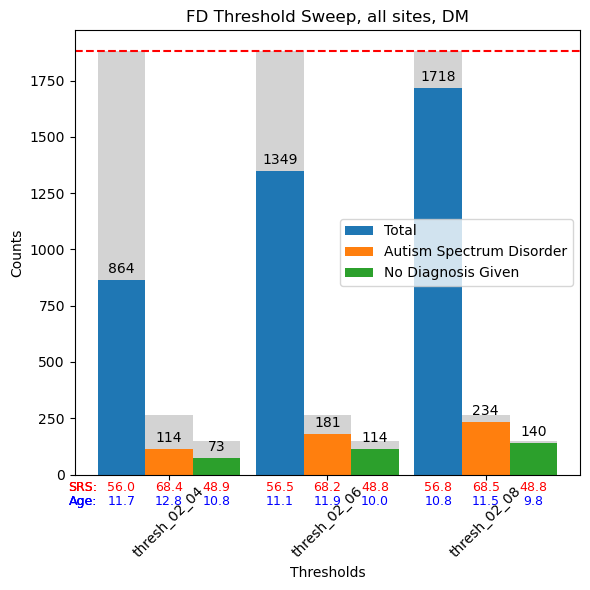

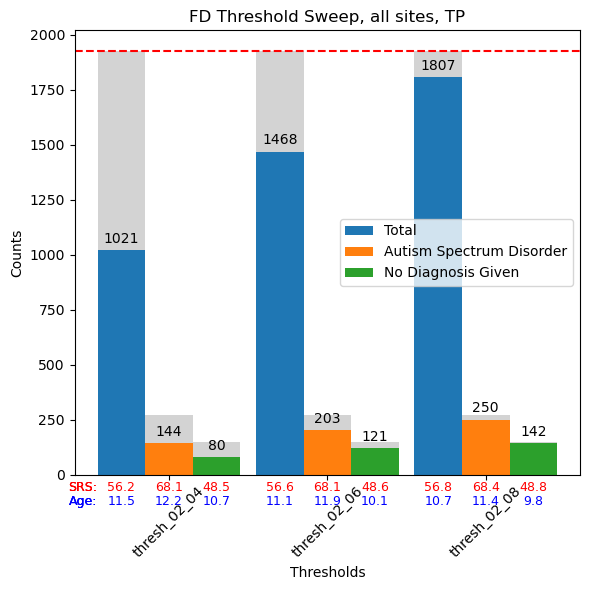

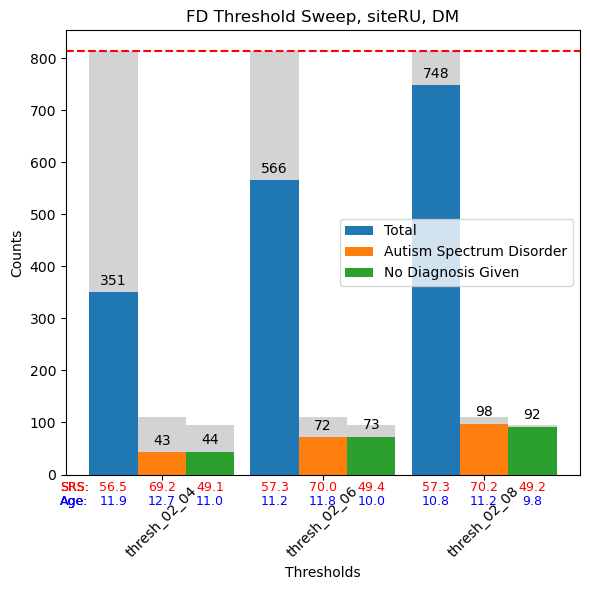

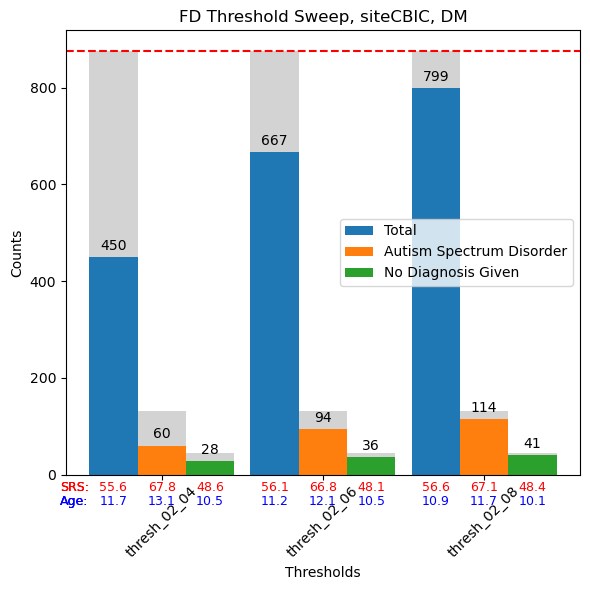

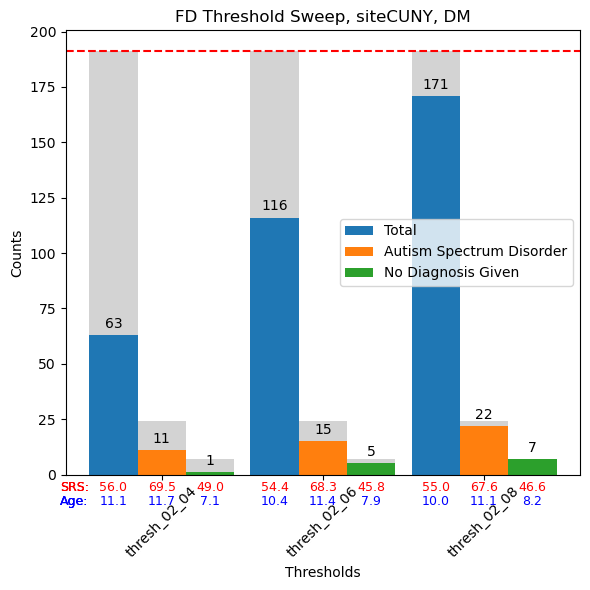

In [165]:
thresholds = ['thresh_02_04', 'thresh_02_06', 'thresh_02_08']
title='FD Threshold Sweep, all sites, DM'
plot_threshold_sweep(all_qc_sweep_dx_DM,thresholds,title)


thresholds = ['thresh_02_04',  'thresh_02_06', 'thresh_02_08']
title='FD Threshold Sweep, all sites, TP'
plot_threshold_sweep(all_qc_sweep_dx_TP,thresholds,title)

title='FD Threshold Sweep, siteRU, DM'
plot_threshold_sweep(all_qc_sweep_dx_DM[all_qc_sweep_dx_DM['ses']=='HBNsiteRU'],thresholds,title)

title='FD Threshold Sweep, siteCBIC, DM'
plot_threshold_sweep(all_qc_sweep_dx_DM[all_qc_sweep_dx_DM['ses']=='HBNsiteCBIC'],thresholds,title)

title='FD Threshold Sweep, siteCUNY, DM'
plot_threshold_sweep(all_qc_sweep_dx_DM[all_qc_sweep_dx_DM['ses']=='HBNsiteCUNY'],thresholds,title)

In [55]:
len(all_qc_sweep_dx_DM)

1879